# Biweekly Report 2: Implementations of In-Class Topics

## By: Simon Julien

## Report Partner: Jackson Curry

### Introduction: 
For this part of the report, we will be implementing and analyzing a number of topics that were covered in class such as random-erasing image augmentation, batch normalization, inception, and VGG which we will be applying to the problem of classification with the Cifar-10 dataset. As we are still familiarizing ourselves with TF, our goal was to build a functional toolkit for ourselves as we carry out our own scientific investigations (in next sections)

In [1]:
#General Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns     #(another plotting module ontop of matplotlib)
import pandas as pd

#All Imports for Tensorflow/Keras
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, ZeroPadding2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets
from tensorflow.keras.regularizers import l2

### Part 1: Random-Erasing Image Augmentation
In this section we attempt to increase the performance of a basic CNN model by altering and increasing the size of the training set using random-erasing augmentation.  For a baseline of performance we first train the CNN model on the default training set that is given to us when we load the cifar10 dataset. 

Next we follow the pseudocode given in the lecture slides to implement an algorithm for randomly altering images in the training set and deleting certain portions of them to be replaced with either black squares or white squares. 

During this process we are able to double the size of our training set.  We then train the exact same CNN model using this new training set to see if we have been able to increase the performance of this model on the exact same validation set as before! 

In [2]:
#importing cifar10 dataset
(X_train_images, y_train_labels), (X_test_images, y_test_labels) = datasets.cifar10.load_data()

#printing dimensions of the train images, train labels, test images, and test labels:
print(f"The dimensions of the training images set is: {X_train_images.shape}")
print(f"The dimensions of the training labels set is: {y_train_labels.shape}")
print(f"The dimensions of the testing images set is: {X_test_images.shape}")
print(f"The dimensions of the testing images set is: {y_test_labels.shape}")

The dimensions of the training images set is: (50000, 32, 32, 3)
The dimensions of the training labels set is: (50000, 1)
The dimensions of the testing images set is: (10000, 32, 32, 3)
The dimensions of the testing images set is: (10000, 1)


In the cell below we define the CNN model that will be trained 3 times using the altered training sets

In [3]:
#First I Normalizing pixel values to be between 0 and 1
X_train_images, X_test_images = X_train_images / 255.0, X_test_images / 255.0

#Building model using Sequential API
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
#model.summary()
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10))

In [4]:
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

results = model.fit(X_train_images, y_train_labels, epochs=5, 
                    validation_data=(X_test_images, y_test_labels))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In the following cell we implemented a function that takes in model predictions and creates a confusion matrix which is visualized using the seaborn library to make it look even better!  We thought that the confusion matrix was really helpful because it allowed us to see which objects our model was having trouble classifying (or commonly classifying as a different object) as well as which objects our model did a great job of classifying!  

Looking at the specific confusion matrix below we can see that our CNN with the default training set struggled with telling the difference between dogs and cats because there were many examples of dogs being classified as cats and vice-versa.  We can also see that this model did really well with correctly classifying automobiles as automobiles since the value along the diagonal here is really high!

Classification Report
              precision    recall  f1-score   support

    airplane       0.56      0.84      0.67      1000
  automobile       0.77      0.84      0.80      1000
        bird       0.56      0.51      0.54      1000
         cat       0.46      0.57      0.51      1000
        deer       0.67      0.55      0.61      1000
         dog       0.67      0.44      0.53      1000
        frog       0.75      0.78      0.76      1000
       horse       0.77      0.71      0.74      1000
        ship       0.77      0.81      0.79      1000
       truck       0.86      0.67      0.75      1000

    accuracy                           0.67     10000
   macro avg       0.68      0.67      0.67     10000
weighted avg       0.68      0.67      0.67     10000



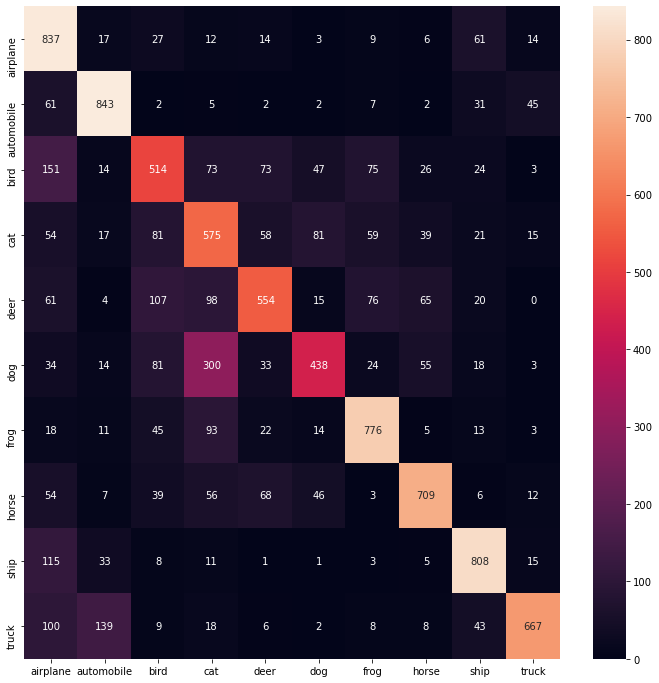

In [5]:
class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
#Here I use the seaborn package to plot the confusion matrix for the predicted results of my model
def plotConfusionMatrix(modelPredictions):
    #rounding the prediction values to whole numbers for classification purposes using np.around()
    confMat = confusion_matrix(y_test_labels,np.argmax(np.around(modelPredictions), axis=1))  
    report = classification_report(y_test_labels,np.argmax(np.around(modelPredictions),axis=1),
                                  target_names=[class_types[i] for i in range(len(class_types))]) 
    print("Classification Report")
    print(report)
    plt.figure(figsize=(12,12))
    seabornHeatMap = sns.heatmap(confMat, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
    figure = seabornHeatMap.get_figure()

    
currPredictions = model.predict(X_test_images)
plotConfusionMatrix(currPredictions)

In the cell below we graph the accuracy that this model had on the training set as well as the testing set.  We can see that as the epochs progress the training set crosses the validation set.  Overall we can see that the accuracy of this CNN model trained using the default training set is able to achieve approximately 65% accuracy on the validation set after 5 epochs.  This will serve as a baseline to see if the random-erasing image augmentation has a positive or negative effect!

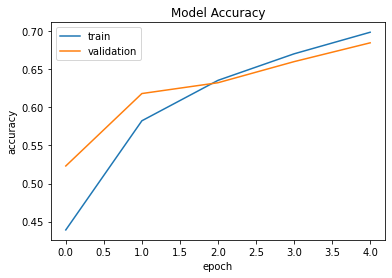

In [6]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='upper left')
plt.show()

Below is the implementation of the random-erasing algorithm we saw on the lecture slides for creating new augmented images.  We visualize the original and altered images side-by-side to show the results.

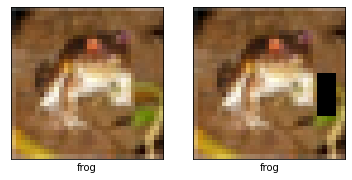

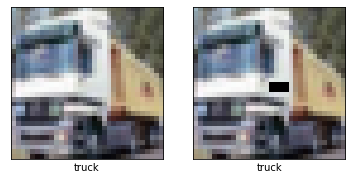

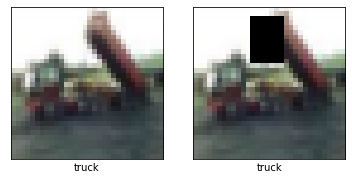

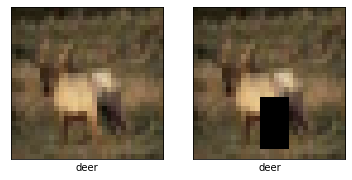

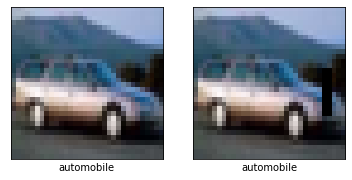

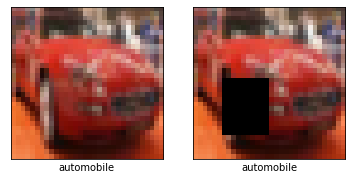

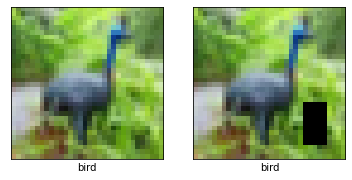

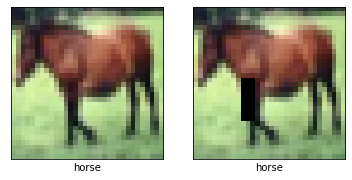

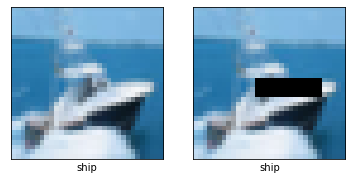

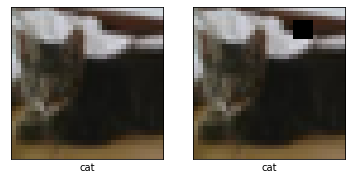

In [7]:
#This function takes in an image from the cifar dataset and will return another image with random erasing and
#replacement with black pixels

def randomErasing(inputImage):
    erasedImage = inputImage.copy()
    flag = True
    while flag:    #this will always be true we basically stay here until we find a viable random erasing box
        #below I define the x and y coordinates of the upper left portion of my bounding box
        xVal = np.random.randint(31,size=1)
        yVal = np.random.randint(31,size=1)
        width = np.random.randint(2,16,size=1)
        height = np.random.randint(2,16,size=1)
        if xVal[0]+width[0]<32 and yVal[0]+height[0]<32:   #this is when we have a valid bounding box!
            #print("valid box found!")
            for filter in range(3):
                for i in range(xVal[0],xVal[0]+width[0]):
                    for j in range(yVal[0],yVal[0]+height[0]):
                        erasedImage[i][j][filter] = 0
            return erasedImage
        else:
            #print("not valid")
            pass

for i in range(10):
    plt.subplot(1,2,1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_images[i])
    plt.xlabel(class_types[y_train_labels[i][0]])
    
    plt.subplot(1,2,2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(randomErasing(X_train_images[i]))
    plt.xlabel(class_types[y_train_labels[i][0]])
    
    plt.show()

In the following cell we use the function we created above to generate an altered image for every image in the original training set.  We then append these altered images to the end of the original training set to create a new training set that has double the size!  We also hope that this random image augmentation will make our CNN model more robust after it trains on this new training set!

The shape of the image training set is now (100000, 32, 32, 3)
The shape of the labels for the training set is now (100000, 1)


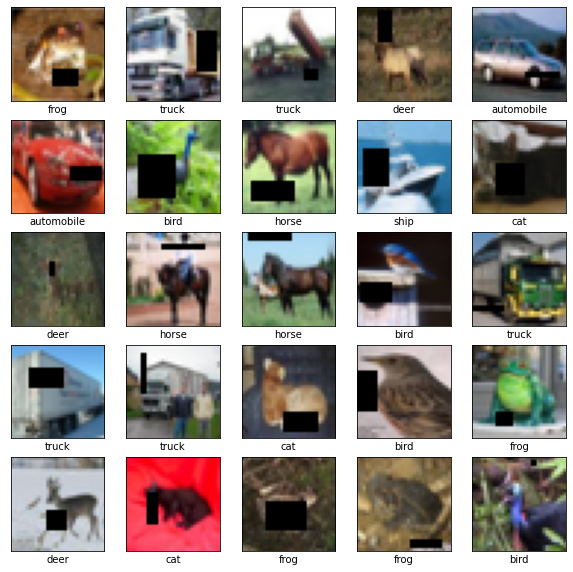

In [8]:
if X_train_images.shape == (50000,32,32,3):   #this if statement is to ensure this cell is only run once to double training set  
    #Now I am doubling the size of our training set
    erasedImages = np.zeros(shape=(50000, 32, 32, 3))
    newLabels = np.zeros(shape=(50000,1))
    for i in range(50000):
        erasedImages[i] = randomErasing(X_train_images[i])
        newLabels[i] = y_train_labels[i][0]

    X_train_images = np.concatenate((X_train_images,erasedImages),axis=0)
    y_train_labels = np.concatenate((y_train_labels,newLabels),axis=0)
    print(f"The shape of the image training set is now {X_train_images.shape}")
    print(f"The shape of the labels for the training set is now {y_train_labels.shape}")

    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_train_images[i+50000])
        plt.xlabel(class_types[int(y_train_labels[i+50000][0])])
    plt.show() 

We now train the same CNN model using the new training set, but keeping all other hyperparameters the same for an accurate comparison to the base case. 

In [9]:
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

results = model.fit(X_train_images, y_train_labels, epochs=5, 
                    validation_data=(X_test_images, y_test_labels))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

We now visualize the results of this retrained model in a confusion matrix.  We can see that now the accuracy on the validation set has increased to approximately 71% which is a 6% increase in accuracy from using this technique which is great!

Classification Report
              precision    recall  f1-score   support

    airplane       0.72      0.79      0.75      1000
  automobile       0.84      0.85      0.85      1000
        bird       0.56      0.65      0.60      1000
         cat       0.46      0.63      0.54      1000
        deer       0.69      0.66      0.67      1000
         dog       0.70      0.48      0.57      1000
        frog       0.88      0.70      0.78      1000
       horse       0.77      0.75      0.76      1000
        ship       0.84      0.81      0.83      1000
       truck       0.83      0.81      0.82      1000

    accuracy                           0.71     10000
   macro avg       0.73      0.71      0.72     10000
weighted avg       0.73      0.71      0.72     10000



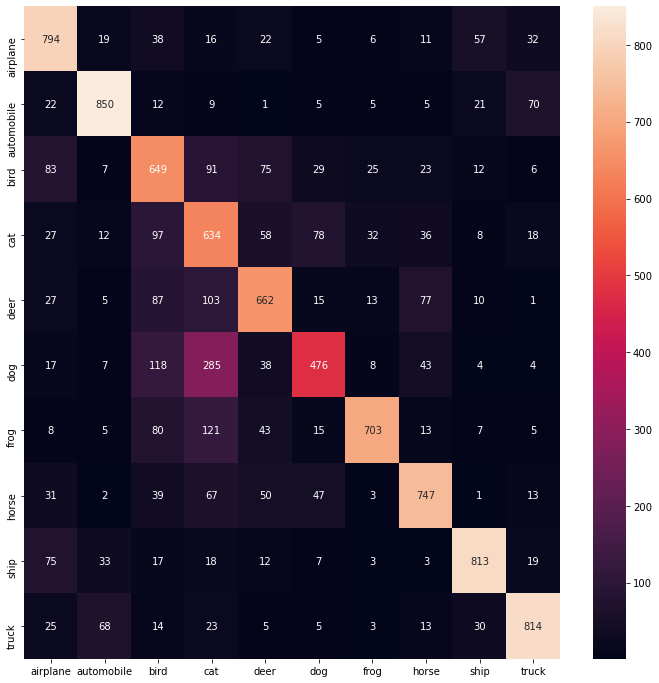

In [10]:
currPredictions = model.predict(X_test_images)
plotConfusionMatrix(currPredictions)

In the plot below we once again see the accuracy results of this new model on the training set as well as the validation set

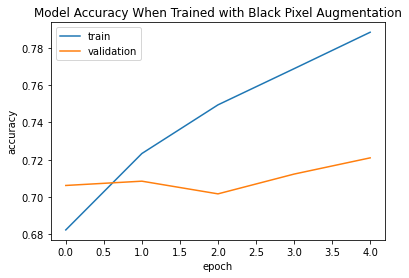

In [11]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy When Trained with Black Pixel Augmentation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='upper left')
plt.show()

We now were interested to see what would happen if we did the random-erasing and replaced the deleted pixels with white pixels instead of black pixels!  Much of this process is the exact same except for where we input the pixel value for white instead of black

The shape of the image training set is now (100000, 32, 32, 3)
The shape of the labels for the training set is now (100000, 1)


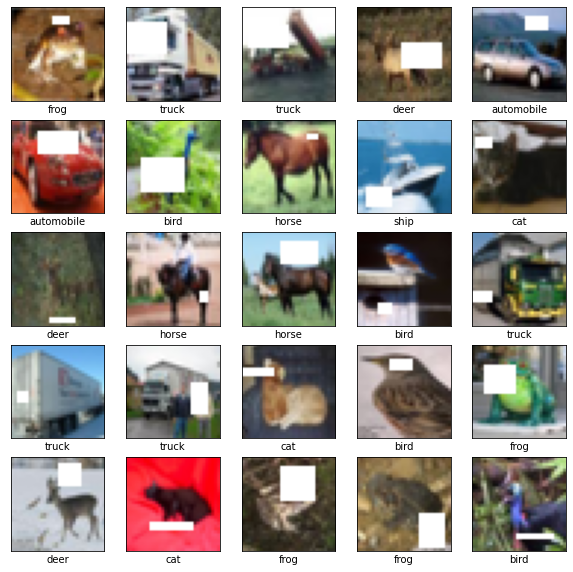

In [12]:
(X_train_images, y_train_labels), (X_test_images, y_test_labels) = datasets.cifar10.load_data()
#Normalizing pixel values to be between 0 and 1
X_train_images, X_test_images = X_train_images / 255.0, X_test_images / 255.0

def randomErasingWhite(inputImage):
    erasedImage = inputImage.copy()
    flag = True
    while flag:    #this will always be true we basically stay here until we find a viable random erasing box
        #below I define the x and y coordinates of the upper left portion of my bounding box
        xVal = np.random.randint(31,size=1)
        yVal = np.random.randint(31,size=1)
        width = np.random.randint(2,16,size=1)
        height = np.random.randint(2,16,size=1)
        if xVal[0]+width[0]<32 and yVal[0]+height[0]<32:  
            #print("valid box found!")
            for filter in range(3):
                for i in range(xVal[0],xVal[0]+width[0]):
                    for j in range(yVal[0],yVal[0]+height[0]):
                        erasedImage[i][j][filter] = 1          #THIS IS THE IMPORTANT CHANGE!!!
            return erasedImage
        else:
            #print("not valid")
            pass
        
if X_train_images.shape == (50000,32,32,3):   #this if statement is to ensure this cell is only run once to double training set  
    #Now I am doubling the size of our training set
    erasedImages = np.zeros(shape=(50000, 32, 32, 3))
    newLabels = np.zeros(shape=(50000,1))
    for i in range(50000):
        erasedImages[i] = randomErasingWhite(X_train_images[i])
        newLabels[i] = y_train_labels[i][0]

    X_train_images = np.concatenate((X_train_images,erasedImages),axis=0)
    y_train_labels = np.concatenate((y_train_labels,newLabels),axis=0)
    print(f"The shape of the image training set is now {X_train_images.shape}")
    print(f"The shape of the labels for the training set is now {y_train_labels.shape}")

    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_train_images[i+50000])
        plt.xlabel(class_types[int(y_train_labels[i+50000][0])])
    plt.show()
    



In [13]:
#re-train existing model with new training set
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

results = model.fit(X_train_images, y_train_labels, epochs=5, 
                    validation_data=(X_test_images, y_test_labels))

Epoch 1/5
3125/3125 [==============================] - 49s 16ms/step - loss: 0.6916 - accuracy: 0.7554 - val_loss: 0.8488 - val_accuracy: 0.7225
Epoch 2/5
3125/3125 [==============================] - 48s 15ms/step - loss: 0.6090 - accuracy: 0.7834 - val_loss: 0.9032 - val_accuracy: 0.7128
Epoch 3/5
3125/3125 [==============================] - 52s 17ms/step - loss: 0.5577 - accuracy: 0.8003 - val_loss: 0.8643 - val_accuracy: 0.7333
Epoch 4/5
3125/3125 [==============================] - 50s 16ms/step - loss: 0.5123 - accuracy: 0.8171 - val_loss: 0.9116 - val_accuracy: 0.7275
Epoch 5/5
3125/3125 [==============================] - 54s 17ms/step - loss: 0.4738 - accuracy: 0.8319 - val_loss: 0.9797 - val_accuracy: 0.7117


Classification Report
              precision    recall  f1-score   support

    airplane       0.69      0.80      0.74      1000
  automobile       0.75      0.89      0.82      1000
        bird       0.48      0.73      0.58      1000
         cat       0.56      0.50      0.53      1000
        deer       0.71      0.60      0.65      1000
         dog       0.66      0.56      0.60      1000
        frog       0.84      0.75      0.79      1000
       horse       0.80      0.73      0.77      1000
        ship       0.83      0.78      0.81      1000
       truck       0.89      0.70      0.78      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



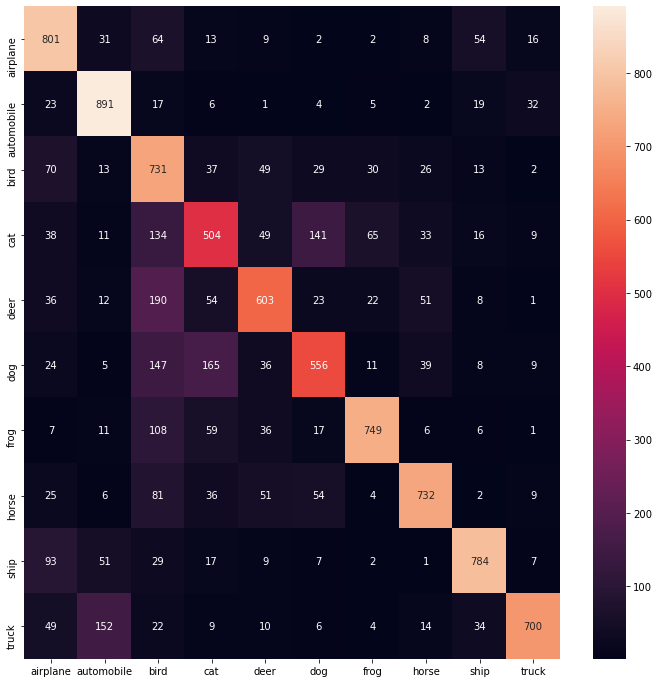

In [14]:
currPredictions = model.predict(X_test_images)
plotConfusionMatrix(currPredictions)

From looking at the results and the confusion matrix it seems that replacing with white pixels instead of black doesn't have any really major effects.  The accuracy is still 70% which is a 5% increase over the baseline.  The interesting thing though with the plot below is that the validation accuracy began decreasing in the 4th and 5th epoch.  We believe that this might be a result of overfitting to a dataset were there are now 2 very similar images for each label.  Also possibly why white might be overfitting more than black is most of the images appear to be pretty light so perhaps the white image augmentation didn't make as much of a change as the black image augmentation which ultimately led to more overfitting!

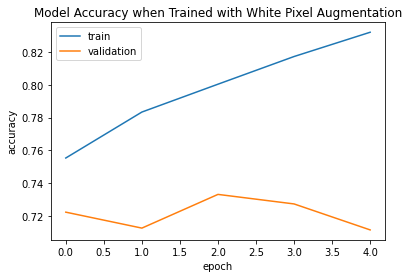

In [15]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy when Trained with White Pixel Augmentation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='upper left')
plt.show()

#### Batch Normalization

The overall purpose of batch normalization is to speed up the training process of inputted data. By normalizing a whole batch of data (specifically on each layer of the NN), the importance of initial weights is reduced and the training can "maximize" its distinctions between classification in the data, increasing its overall learning rate. This means we need less input data to distinguish the value between two seeming small values in data, and using a random data point won't impact the accuracy of training the data (withought being normalized a random single data point could be much further from the minimum of the loss function than another). We can see the results of this in implementation:

In [16]:
from tensorflow.keras.datasets import cifar10 #New dataset
import matplotlib.pyplot as plot

(x_train, y_train), (x_test, y_test) = cifar10.load_data() #load data
x_train=x_train.astype("float32") / 255.0 #convert to better computational type and normalize
x_test=x_test.astype("float32") / 255.0


In [17]:
def my_model(): #defining model as python function for diversity
    inputs = keras.Input(shape=(32, 32, 3)) 
    x=layers.Conv2D(32, 3)(inputs)#convolution
    #No Batch Normalization
    x=keras.activations.relu(x)
    x=layers.MaxPooling2D()(x)
    x=layers.Conv2D(64, 3)(x) #layer 2
    #No Batch Normalization
    x=keras.activations.relu(x)
    x=layers.MaxPooling2D()(x)
    x=layers.Conv2D(128, 3)(x) #layer 3
    #No Batch Normalization
    x=keras.activations.relu(x)
    x=layers.Flatten()(x)
    x=layers.Dense(64, activation="relu")(x) #dense layer
    outputs=layers.Dense(10)(x)
    model=keras.Model(inputs=inputs, outputs=outputs)
    return model

model=my_model()

print(model.summary())

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(lr=3e-4), #Adam
    metrics=["accuracy"],
)

history=model.fit(x_train,y_train,batch_size=64,epochs=20,verbose=2) #train



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
tf.nn.relu_1 (TFOpLambda)    (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0     

/Users/simon/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
782/782 - 17s - loss: 1.6841 - accuracy: 0.3822
Epoch 2/20
782/782 - 17s - loss: 1.3655 - accuracy: 0.5125
Epoch 3/20
782/782 - 17s - loss: 1.2326 - accuracy: 0.5660
Epoch 4/20
782/782 - 17s - loss: 1.1284 - accuracy: 0.6050
Epoch 5/20
782/782 - 17s - loss: 1.0428 - accuracy: 0.6364
Epoch 6/20
782/782 - 19s - loss: 0.9774 - accuracy: 0.6599
Epoch 7/20
782/782 - 19s - loss: 0.9158 - accuracy: 0.6807
Epoch 8/20
782/782 - 19s - loss: 0.8744 - accuracy: 0.6959
Epoch 9/20
782/782 - 18s - loss: 0.8305 - accuracy: 0.7125
Epoch 10/20
782/782 - 18s - loss: 0.7955 - accuracy: 0.7244
Epoch 11/20
782/782 - 21s - loss: 0.7627 - accuracy: 0.7357
Epoch 12/20
782/782 - 20s - loss: 0.7293 - accuracy: 0.7475
Epoch 13/20
782/782 - 18s - loss: 0.6986 - accuracy: 0.7590
Epoch 14/20
782/782 - 578s - loss: 0.6691 - accuracy: 0.7697
Epoch 15/20
782/782 - 22s - loss: 0.6448 - accuracy: 0.7765
Epoch 16/20
782/782 - 24s - loss: 0.6187 - accuracy: 0.7845
Epoch 17/20
782/782 - 24s - loss: 0.5911 - accur

Using an example from previous work on implementing convolution to the cifar10 dataset, we have removed the batch normalizations at the beginning of each layer's inputs. As predicted the accuracy of the training set is still notably low and is suggesting that it needs much more epochs to near a reasonable value. Below we have re-implemented the batch normalization.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
tf.nn.relu_3 (TFOpLambda)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256 

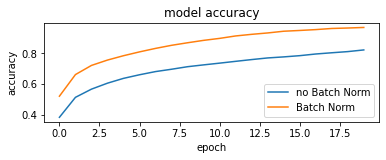

In [18]:
plot.subplot(2,1,1)
plot.plot(history.history['accuracy'])

def my_model2(): #defining model as python function for diversity
    inputs = keras.Input(shape=(32, 32, 3)) 
    x=layers.Conv2D(32, 3)(inputs)#convolution
    x=layers.BatchNormalization()(x)
    x=keras.activations.relu(x)
    x=layers.MaxPooling2D()(x)
    x=layers.Conv2D(64, 3)(x) #layer 2
    x=layers.BatchNormalization()(x)
    x=keras.activations.relu(x)
    x=layers.MaxPooling2D()(x)
    x=layers.Conv2D(128, 3)(x) #layer 3
    x=layers.BatchNormalization()(x)
    x=keras.activations.relu(x)
    x=layers.Flatten()(x)
    x=layers.Dense(64, activation="relu")(x) #dense layer
    outputs=layers.Dense(10)(x)
    model=keras.Model(inputs=inputs, outputs=outputs)
    return model

model2=my_model2()

print(model2.summary())

model2.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(lr=3e-4), #Adam 
    metrics=["accuracy"],
)

history2=model2.fit(x_train,y_train,batch_size=64,epochs=20,verbose=2) #train



plot.plot(history2.history['accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plot.legend(['no Batch Norm', 'Batch Norm'], loc='lower right')
plot.show()

Redoing this with gradient decent optimization (rather than Adam) because the benefits of batch normalizations are a little easier to visualize/ conceptualize. 

Epoch 1/20
782/782 - 20s - loss: 1.9479 - accuracy: 0.2862
Epoch 2/20
782/782 - 21s - loss: 1.4630 - accuracy: 0.4744
Epoch 3/20
782/782 - 21s - loss: 1.2556 - accuracy: 0.5544
Epoch 4/20
782/782 - 20s - loss: 1.1011 - accuracy: 0.6115
Epoch 5/20
782/782 - 21s - loss: 0.9752 - accuracy: 0.6561
Epoch 6/20
782/782 - 20s - loss: 0.8716 - accuracy: 0.6932
Epoch 7/20
782/782 - 19s - loss: 0.7836 - accuracy: 0.7260
Epoch 8/20
782/782 - 20s - loss: 0.7032 - accuracy: 0.7546
Epoch 9/20
782/782 - 19s - loss: 0.6352 - accuracy: 0.7760
Epoch 10/20
782/782 - 21s - loss: 0.5647 - accuracy: 0.8009
Epoch 11/20
782/782 - 22s - loss: 0.5006 - accuracy: 0.8228
Epoch 12/20
782/782 - 21s - loss: 0.4490 - accuracy: 0.8404
Epoch 13/20
782/782 - 20s - loss: 0.3957 - accuracy: 0.8601
Epoch 14/20
782/782 - 21s - loss: 0.3463 - accuracy: 0.8759
Epoch 15/20
782/782 - 21s - loss: 0.3101 - accuracy: 0.8909
Epoch 16/20
782/782 - 21s - loss: 0.2829 - accuracy: 0.8984
Epoch 17/20
782/782 - 20s - loss: 0.2590 - accura

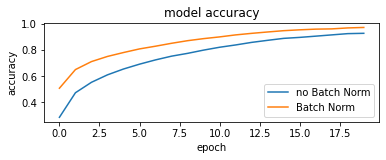

In [19]:
#without Batch Norm

model=my_model()

#print(model.summary())

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.SGD(learning_rate=0.1),

    metrics=["accuracy"],
)

history=model.fit(x_train,y_train,batch_size=64,epochs=20,verbose=2) #train


plot.subplot(2,1,1)
plot.plot(history.history['accuracy'])
## With Batch Norm


model2=my_model2()

#print(model2.summary())

model2.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.SGD(learning_rate=0.1),

    metrics=["accuracy"],
)

history2=model2.fit(x_train,y_train,batch_size=64,epochs=20,verbose=2) #train


plot.plot(history2.history['accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plot.legend(['no Batch Norm', 'Batch Norm'], loc='lower right')
plot.show()

From looking fist at the model summaries, the batch normalization increased the amount of total parameters, the amount of trainable parameters, and added 448 non-trainable parameters which improves the stability and speed of the NN as well as adds some complexity. After putting these models to use with the dataset, we can see that the batch normalization increased the accuracy of the model, and plateaus near the 20th epoch while the case without any batch normalization is still improving in accuracy by the 20th epoch. This difference is seen most in the gradient decent optimization. The batch normalizations did take a few more seconds to run each epoch due to some additional complexity, which was also predicted. Overall, it is clear that batch normalization allows more accurate results per epoch in a training set (ie quicker training). 

#### Visual Geometery Group (VGG)

A VGG block is a group of convolutional NN layers with equivalent numbers of filters and the same padding so the ouput is the same as in the input through each filter. After the pooling, an activation function and max pooling are applied to read just data. Here we will include the functional API, that was partially investigated in the last report.

In [20]:
pip install update pydotplus

Note: you may need to restart the kernel to use updated packages.


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 64)      0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


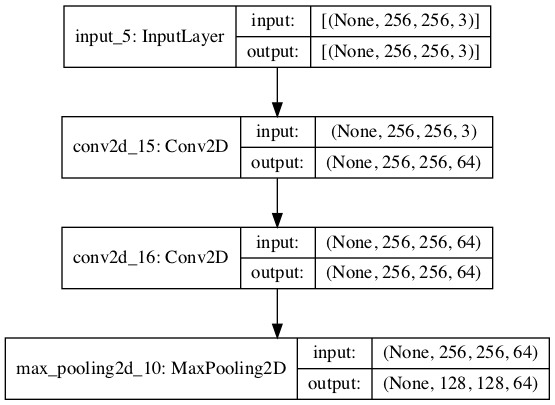

In [21]:
# VGG block
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils.vis_utils import plot_model



# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
    for i in range(n_conv):
        layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in) #convolution with padding and relu activation
    layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in) #max pooling
    return layer_in

# define model input
visible = Input(shape=(256, 256, 3))
# add vgg module
layer = vgg_block(visible, 64, 2)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture

plot_model(model,  to_file='vgg_block.png', show_shapes=True)

Above shows a typical implementation of VGG blocks that has two convolutional layerwss with 64 filters each, then passed through max pooling. According to the tutorial, it is common to see this standard process of VGG blocks where multiple blocks are implemented with increasing filter numbers as the model gets more deep. This is implemented below.

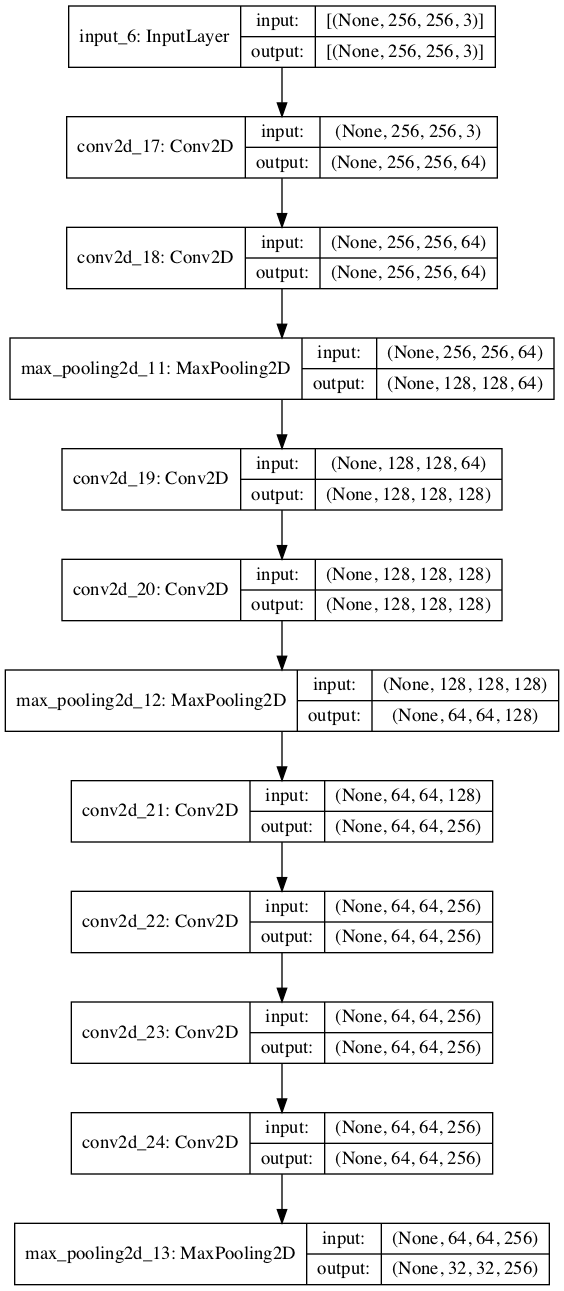

In [22]:
# Using same model function
visible = Input(shape=(256, 256, 3))
# block 1
layer = vgg_block(visible, 64, 2)
# block 2
layer = vgg_block(layer, 128, 2) #pass in previous layer
# block 3
layer = vgg_block(layer, 256, 4) #pass in previous layer
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
#model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='multiple_vgg_blocks.png')

#### Inception

An inception model is one where multiple convolutional layers with different filter sizes, and a max pooling layer, are concatenated. This allows the learning to occure at multiple scales incoorperating differeent filters in parallel. In this implementation, we implement the parallel convolutional layers with 1x1, 3x3, and 5x5 filters. 

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 32, 32, 32)   128         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 32, 32, 128)  3584        input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 32, 32, 64)   4864        input_7[0][0]                    
____________________________________________________________________________________________

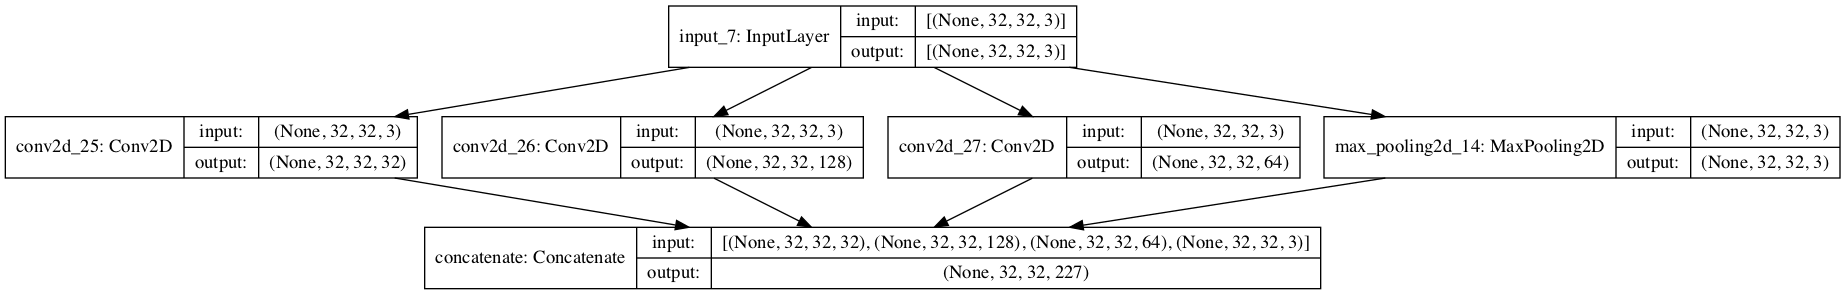

In [23]:
# example of creating a CNN with an inception module
from keras.layers.merge import concatenate

# function for creating a naive inception block
def inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1) #added to running documentation doc
    return layer_out


# define model input
visible = Input(shape=(32, 32, 3))
# add inception module
layer = inception_module(visible, 32, 128, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

As seen in the nice visualization above (part of the pydot library), we can see that the convolutional layers and the max pooling are all being performed in parallel and then being concatenated into the output of the model. This allowed us to not have to pick between the number of filters or pooling we chose to implement between layers. Instead, we use them all (with the max pooling using "same" padding)! 